In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data_path = r'C:\Users\aaani\OneDrive - Birmingham City University\Postgrad\Dissertation\Data'

In [20]:
# Define the columns to keep, this is done before loading the data to save on space complexity 

admissions_cols = ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'race', 'hospital_expire_flag']
diagnoses_cols = ['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version']
d_icd_diagnoses_cols = ['icd_code', 'icd_version']
d_labitems_cols = ['itemid', 'label']
labevents_cols = ['subject_id', 'hadm_id', 'itemid', 'charttime', 'valuenum']

icustays_cols = ['subject_id', 'hadm_id', 'stay_id', 'outtime', 'los']
chartevents_cols = ['subject_id', 'hadm_id', 'itemid', 'charttime', 'valuenum', 'stay_id']
d_items_cols = ['itemid', 'label']



In [31]:
# Initialising dfs

#hospital
admissions = pd.read_csv(f'{data_path}/admissions.csv.gz', usecols=admissions_cols)
patients = pd.read_csv(f'{data_path}/patients.csv.gz')
diagnoses = pd.read_csv(f'{data_path}/diagnoses_icd.csv.gz', usecols=diagnoses_cols)
d_icd_diagnoses = pd.read_csv(f'{data_path}/d_icd_diagnoses.csv.gz', usecols=d_icd_diagnoses_cols)
d_labitems = pd.read_csv(f'{data_path}/d_labitems.csv.gz', usecols=d_labitems_cols)
lab = pd.read_csv(f'{data_path}/labevents_last24h.csv.gz', usecols=labevents_cols, parse_dates=['charttime'])


In [32]:
#icu
icustays = pd.read_csv(f'{data_path}/icustays.csv.gz', usecols=icustays_cols, parse_dates=['outtime'])
chartevents = pd.read_csv(f'{data_path}/chartevents_last24h.csv.gz', parse_dates=['charttime'], usecols=chartevents_cols)
d_items = pd.read_csv(f'{data_path}/d_items.csv.gz', usecols=d_items_cols)

In [ ]:
# Define the chunk size
chunk_size = 10_000_000

# This flag ensures we only write the header once
first_chunk = True

# Create a loop that reads the massive labevents file in small chunks
for chunk in pd.read_csv(f'{data_path}/labevents.csv.gz', chunksize=chunk_size, parse_dates=['charttime']):
    
    # Merge the chunk with admissions to get the 'dischtime' for each lab event
    chunk_with_dischtime = pd.merge(chunk, admissions, on=['subject_id', 'hadm_id'], how='inner')
    
    # Calculate the time difference in hours from the lab event to hospital discharge
    time_delta_hours = (chunk_with_dischtime['dischtime'] - chunk_with_dischtime['charttime']).dt.total_seconds() / 3600
    
    # Filter the chunk to keep only labs from the last 24 hours before discharge
    filtered_chunk = chunk_with_dischtime[(time_delta_hours >= 0) & (time_delta_hours <= 24)]
    
    # If the filtered chunk contains any data, save it to our new CSV file
    if not filtered_chunk.empty:
        if first_chunk:
            # For the first chunk, create a new file ('mode=w') and write the header
            filtered_chunk.to_csv('labevents_last24h.csv', index=False, mode='w', header=True)
            first_chunk = False
        else:
            # For all subsequent chunks, append ('mode=a') to the file without the header
            filtered_chunk.to_csv('labevents_last24h.csv', index=False, mode='a', header=False)
            
    print(f"Processed a chunk of {chunk_size} rows...")

print("\nFinished processing labevents. A new, much smaller file 'labevents_last24h.csv' has been created.")

In [ ]:
# Define the chunk size
chunk_size = 10_000_000 # 10 million rows at a time

# This flag ensures we only write the header once
first_chunk = True

# Create a loop that reads the massive chartevents file in small chunks
for chunk in pd.read_csv(f'{data_path}/chartevents.csv.gz', chunksize=chunk_size, parse_dates=['charttime']):
    
    # Merge the chunk with icustays to get the 'outtime' for each event
    chunk_with_outtime = pd.merge(chunk, icustays, on=['subject_id', 'hadm_id', 'stay_id'], how='inner')
    
    # Calculate the time difference in hours from the event to ICU discharge
    time_delta_hours = (chunk_with_outtime['outtime'] - chunk_with_outtime['charttime']).dt.total_seconds() / 3600
    
    # Filter the chunk to keep only events from the last 24 hours before ICU discharge
    filtered_chunk = chunk_with_outtime[(time_delta_hours >= 0) & (time_delta_hours <= 24)]
    
    # If the filtered chunk contains any data, save it to our new CSV file
    if not filtered_chunk.empty:
        if first_chunk:
            # For the first chunk, create a new .gz file and write the header
            filtered_chunk.to_csv(
                'chartevents_last24h.csv.gz', 
                index=False, 
                mode='w', 
                header=True, 
                compression='gzip'
            )
            first_chunk = False
    else:
        # For all subsequent chunks, append to the .gz file without the header
        filtered_chunk.to_csv(
            'chartevents_last24h.csv.gz', 
            index=False, 
            mode='a', 
            header=False, 
            compression='gzip'
        )
            
    print(f"Processed a chunk of {chunk_size} rows...")

print("\nFinished processing chartevents. A new, much smaller file 'chartevents_last24h.csv.gz' has been created.")

In [33]:
# drop values where valuenum is null
lab= lab.dropna(subset=['valuenum'])
chartevents = chartevents.dropna(subset=['valuenum'])


In [34]:
# merged patients to multiple links patient to their diagnoses, lab results, and ICU stays

# used left joins on all so no data is lost

# merged patients with their hospital admissions
merged = pd.merge(admissions, patients, on='subject_id', how='left')

# merge icd codes with their descriptions
diag = pd.merge(diagnoses, d_icd_diagnoses, on=['icd_code', 'icd_version'], how='left')
merged = pd.merge(merged, diag, on= ['subject_id' , 'hadm_id'], how='left') #back to the main merge

# icu stay info
merged = pd.merge(merged, icustays, on=['subject_id' , 'hadm_id'], how='left')

# add labels to lab events
lab = pd.merge(lab, d_labitems, on='itemid', how='left')
chartevents = pd.merge(chartevents, d_items, on='itemid', how='left')

top_20_labs = lab['label'].value_counts().nlargest(20).index #20 most common lab tests
lab_filtered = lab[lab['label'].isin(top_20_labs)] #new fd that onlt has the top 20 lab results - smaller size

lab_features = lab_filtered.groupby(['hadm_id', 'label'])['valuenum'].agg(['mean', 'min', 'max']).unstack(level='label')
lab_features.columns = ['_'.join(col).strip() for col in lab_features.columns.values]
lab_features = lab_features.reset_index()

top_20_charts = chartevents['label'].value_counts().nlargest(20).index # 20 most common chart events
charts_filtered = chartevents[chartevents['label'].isin(top_20_charts)]

chartevents_features = charts_filtered.groupby(['stay_id', 'label'])['valuenum'].agg(['mean', 'min', 'max']).unstack(level='label')

chartevents_features.columns = ['_'.join(col).strip() for col in chartevents_features.columns.values]
chartevents_features = chartevents_features.reset_index()

merged = pd.merge(merged, lab_features, on=['hadm_id'], how='left')
merged = pd.merge(merged, chartevents_features, on=['stay_id'], how='left')

merged.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6599888 entries, 0 to 6599887
Columns: 137 entries, subject_id to max_Temperature Fahrenheit
dtypes: datetime64[ns](1), float64(124), int64(5), object(7)
memory usage: 6.7+ GB


In [ ]:
merged.to_csv('final_dataset.csv.gz', index=False, compression='gzip')

In [3]:
df_info = pd.read_csv(f'{data_path}/final_dataset.csv.gz', nrows=1)


df = pd.read_csv(f'{data_path}/final_dataset.csv.gz')

In [15]:
# creating a dataset that removes duplicate patients, for analysis
unique = df.drop_duplicates(subset=['subject_id']).copy()

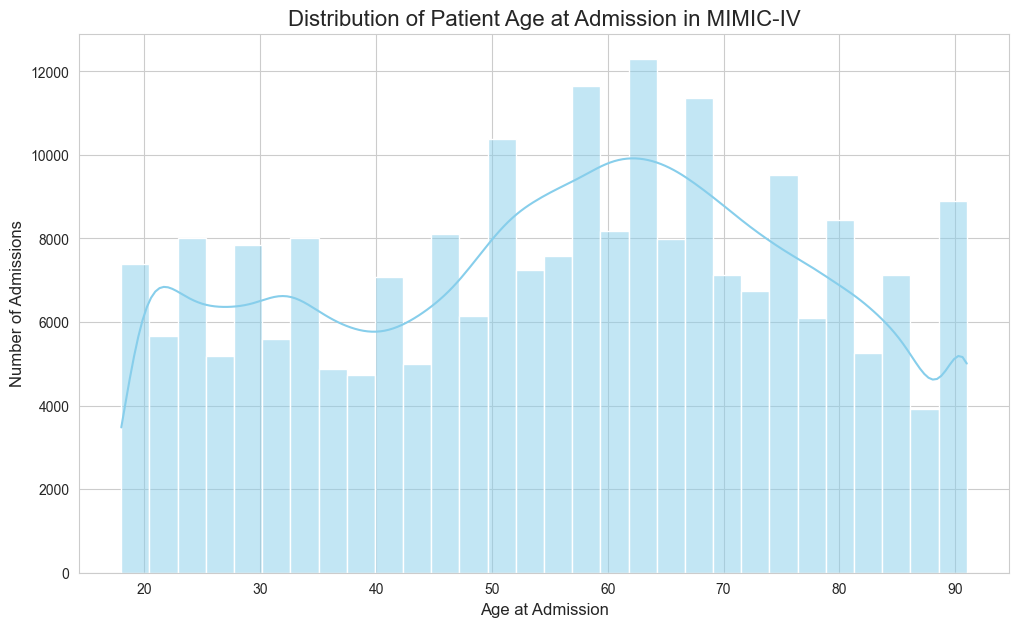

In [7]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

sns.histplot(unique['anchor_age'], bins=30, kde=True, color='skyblue')


plt.title('Distribution of Patient Age at Admission in MIMIC-IV', fontsize=16)
plt.xlabel('Age at Admission', fontsize=12)
plt.ylabel('Number of Admissions', fontsize=12)

# Saving the plot as an image file 
plt.savefig('age_distribution.png')


In [ ]:
# Displaying unique anchor years
unique_anchor_years = unique['anchor_year_group'].unique()
unique_anchor_years.sort()
print("Unique Anchor Years:", unique_anchor_years)

In [9]:
historical_groups = ['2008 - 2010', '2011 - 2013', '2014 - 2016']
contemporary_groups = ['2017 - 2019', '2020 - 2022']

historical = unique[unique['anchor_year_group'].isin(historical_groups)]
contemporary = unique[unique['anchor_year_group'].isin(contemporary_groups)]

historical_age_distribution = historical['anchor_age'].describe()
contemporary_age_distribution = contemporary['anchor_age'].describe()

print("Historical Age Distribution:\n", historical_age_distribution)
print("\nContemporary Age Distribution:\n", contemporary_age_distribution)



Historical Age Distribution:
 count    156747.000000
mean         54.860514
std          20.190226
min          18.000000
25%          38.000000
50%          56.000000
75%          71.000000
max          91.000000
Name: anchor_age, dtype: float64

Contemporary Age Distribution:
 count    66705.000000
mean        57.421078
std         20.227090
min         18.000000
25%         41.000000
50%         60.000000
75%         73.000000
max         91.000000
Name: anchor_age, dtype: float64


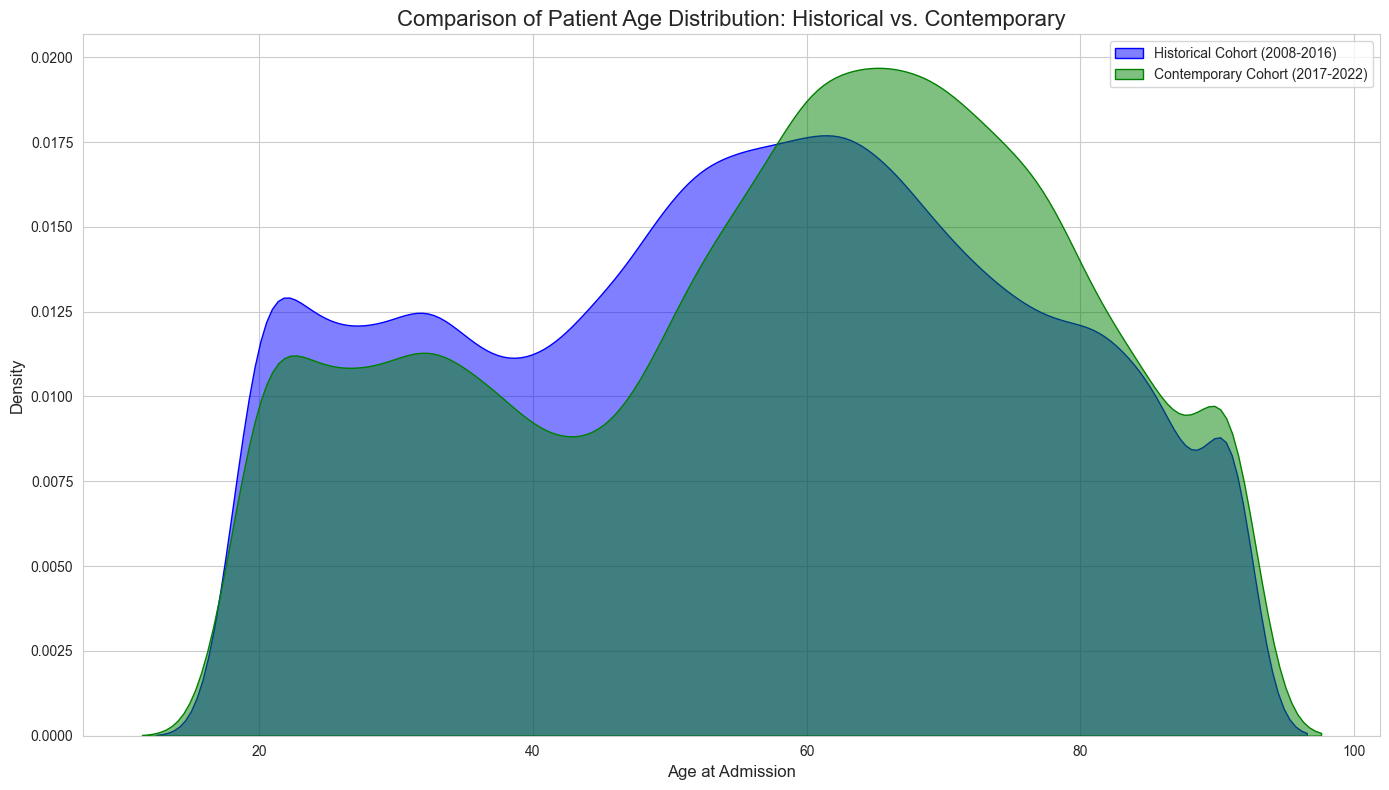

In [10]:
sns.set_style("whitegrid")

# Create a figure for the plot
plt.figure(figsize=(14, 8))

# Plot the distribution of age for the historical cohort
sns.kdeplot(historical['anchor_age'], label='Historical Cohort (2008-2016)', color='blue', fill=True, alpha=0.5)

# Plot the distribution of age for the contemporary cohort on the same axes
sns.kdeplot(contemporary['anchor_age'], label='Contemporary Cohort (2017-2022)', color='green', fill=True, alpha=0.5)

# Add titles, labels, and a legend
plt.title('Comparison of Patient Age Distribution: Historical vs. Contemporary', fontsize=16)
plt.xlabel('Age at Admission', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig('age_distribution_comparison.png')

#This is important as it provided visual evidence of a data drift


In [11]:
# count the unique race categories
unique_race = unique['race'].unique()
unique_race.sort()
print("Unique Race Categories:", unique_race)

Unique Race Categories: ['AMERICAN INDIAN/ALASKA NATIVE' 'ASIAN' 'ASIAN - ASIAN INDIAN'
 'ASIAN - CHINESE' 'ASIAN - KOREAN' 'ASIAN - SOUTH EAST ASIAN'
 'BLACK/AFRICAN' 'BLACK/AFRICAN AMERICAN' 'BLACK/CAPE VERDEAN'
 'BLACK/CARIBBEAN ISLAND' 'HISPANIC OR LATINO'
 'HISPANIC/LATINO - CENTRAL AMERICAN' 'HISPANIC/LATINO - COLUMBIAN'
 'HISPANIC/LATINO - CUBAN' 'HISPANIC/LATINO - DOMINICAN'
 'HISPANIC/LATINO - GUATEMALAN' 'HISPANIC/LATINO - HONDURAN'
 'HISPANIC/LATINO - MEXICAN' 'HISPANIC/LATINO - PUERTO RICAN'
 'HISPANIC/LATINO - SALVADORAN' 'MULTIPLE RACE/ETHNICITY'
 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER' 'OTHER'
 'PATIENT DECLINED TO ANSWER' 'PORTUGUESE' 'SOUTH AMERICAN'
 'UNABLE TO OBTAIN' 'UNKNOWN' 'WHITE' 'WHITE - BRAZILIAN'
 'WHITE - EASTERN EUROPEAN' 'WHITE - OTHER EUROPEAN' 'WHITE - RUSSIAN']


In [16]:
# Define the mapping for the race categories for better readability

race_mapping = {
    'ASIAN - ASIAN INDIAN': 'ASIAN',
    'ASIAN - CHINESE': 'ASIAN',
    'ASIAN - KOREAN': 'ASIAN',
    'ASIAN - SOUTH EAST ASIAN': 'ASIAN',
    'BLACK/AFRICAN': 'BLACK',
    'BLACK/AFRICAN AMERICAN': 'BLACK',
    'BLACK/CAPE VERDEAN': 'BLACK',
    'BLACK/CARIBBEAN ISLAND': 'BLACK',
    'HISPANIC OR LATINO': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - COLUMBIAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - CUBAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - DOMINICAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - GUATEMALAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - HONDURAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - MEXICAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - PUERTO RICAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - SALVADORAN': 'HISPANIC/LATINO',
    'WHITE - BRAZILIAN': 'WHITE',
    'WHITE - EASTERN EUROPEAN': 'WHITE',
    'WHITE - OTHER EUROPEAN': 'WHITE',
    'WHITE - RUSSIAN': 'WHITE',
    'PORTUGUESE': 'WHITE',
    'SOUTH AMERICAN': 'HISPANIC/LATINO',
    'UNABLE TO OBTAIN': 'OTHER/UNKNOWN',
    'UNKNOWN': 'OTHER/UNKNOWN',
    'PATIENT DECLINED TO ANSWER': 'OTHER/UNKNOWN',
    'OTHER': 'OTHER/UNKNOWN',
    'AMERICAN INDIAN/ALASKA NATIVE': 'OTHER/UNKNOWN',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'OTHER/UNKNOWN',
    'MULTIPLE RACE/ETHNICITY': 'OTHER/UNKNOWN'
}


unique['race_grouped'] = unique['race'].replace(race_mapping)
print(unique['race_grouped'].value_counts())


race_grouped
WHITE              148212
BLACK               28659
OTHER/UNKNOWN       24597
HISPANIC/LATINO     12324
ASIAN                9660
Name: count, dtype: int64


In [17]:
historical = unique[unique['anchor_year_group'].isin(historical_groups)]
contemporary = unique[unique['anchor_year_group'].isin(contemporary_groups)]

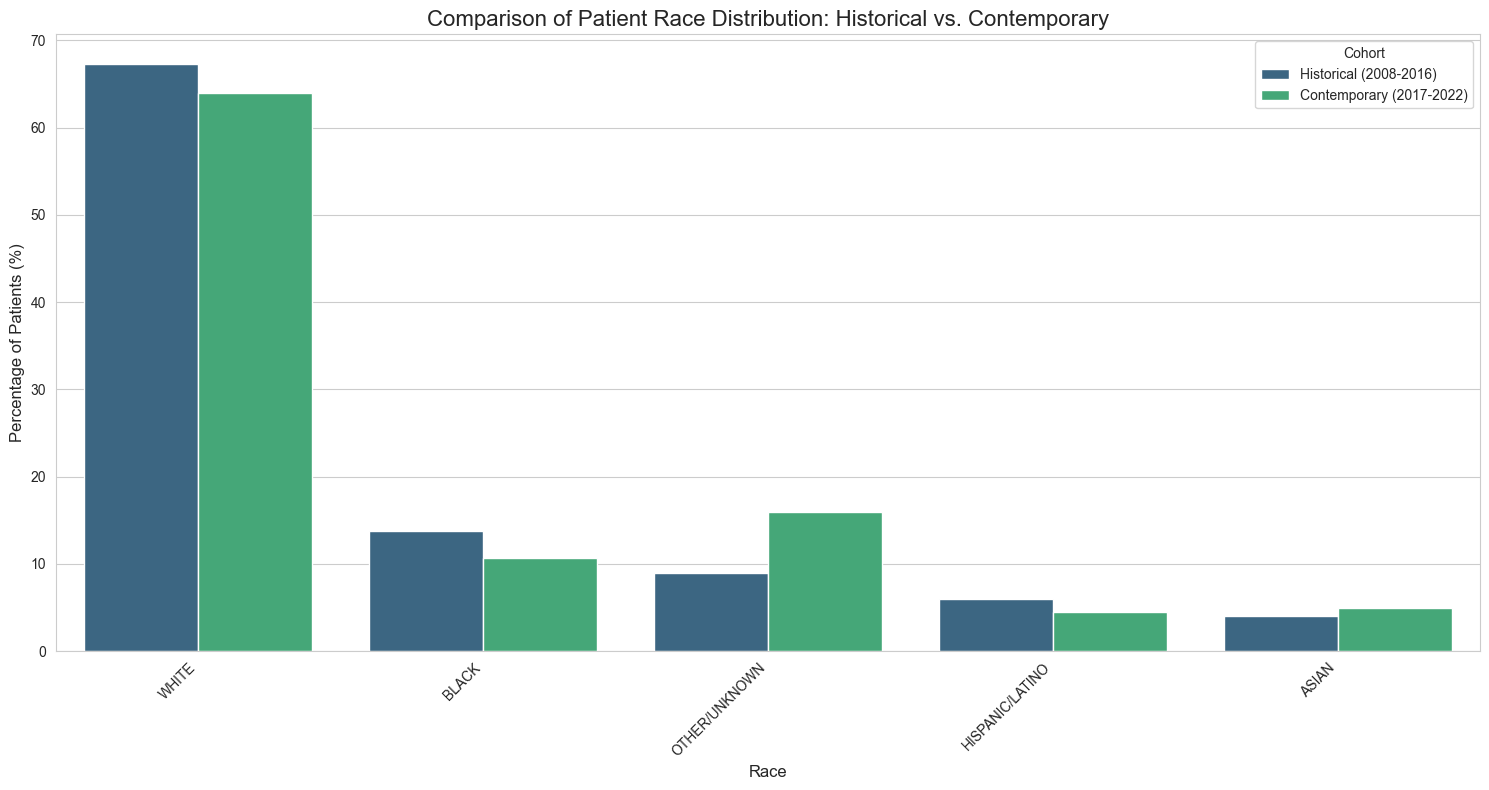

In [18]:
# Calculate the percentage distribution for the historical cohort
historical_race_dist = historical['race_grouped'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
historical_race_dist['Cohort'] = 'Historical (2008-2016)'

# Calculate the percentage distribution for the contemporary cohort
contemporary_race_dist = contemporary['race_grouped'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
contemporary_race_dist['Cohort'] = 'Contemporary (2017-2022)'


combined_race_dist = pd.concat([historical_race_dist, contemporary_race_dist])

# Visualisation 
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

# Create the bar plot
barplot = sns.barplot(data=combined_race_dist, x='race_grouped', y='percentage', hue='Cohort', palette='viridis')

# Add titles and labels
plt.title('Comparison of Patient Race Distribution: Historical vs. Contemporary', fontsize=16)
plt.xlabel('Race', fontsize=12)
plt.ylabel('Percentage of Patients (%)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()

# Save the plot
plt.savefig('race_distribution_comparison.png')